In [2]:
# Task A – Determine flight path bounding box
import time
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd
import os

# --- Paths ---
pos_path = "20200910_BlakesOpening_site3_flight1z.pos"
gpkg_path = "uas_flight.gpkg"
layer_name = "flight_path"

t0 = time.perf_counter()

# --- Read .pos file ---
col_names = [
    "timestamp", "lat", "lon", "height_m",
    "Q", "Q_text", "sats",
    "SDNorth_m", "SDEast_m", "SDHeight_m", "StdDev_m"
]

df = pd.read_csv(
    pos_path,
    comment="%",        # skip RTKLIB header rows
    header=None,
    names=col_names,
    dtype={
        "lat": float, "lon": float, "height_m": float,
        "Q": "Int64", "sats": "Int64",
        "SDNorth_m": float, "SDEast_m": float, "SDHeight_m": float, "StdDev_m": float
    }
)

read_time = time.perf_counter() - t0

# Drop rows without coordinates
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# --- Create GeoDataFrame in WGS84 (EPSG:7844) and project to MGA2020 / Zone 55 (EPSG:7855) ---
gdf_wgs84 = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])],
    crs="EPSG:7844"
)
gdf = gdf_wgs84.to_crs("EPSG:7855")

# --- Bounding box + height range ---
minx, miny, maxx, maxy = gdf.total_bounds
min_h = float(np.nanmin(gdf["height_m"]))
max_h = float(np.nanmax(gdf["height_m"]))

# --- LineString and length ---
line = LineString(list(gdf.geometry.values))
line_gdf = gpd.GeoDataFrame(
    {"total_length_m": [line.length]},
    geometry=[line],
    crs=gdf.crs
)

# Save to GeoPackage
if os.path.exists(gpkg_path):
    os.remove(gpkg_path)
line_gdf.to_file(gpkg_path, layer=layer_name, driver="GPKG")

calc_time = time.perf_counter() - t0 - read_time

# --- Nicely formatted printouts ---
def fmt_m(x): return f"{x:,.3f} m"

print("A) Determine flight path bounding box — outputs")
print("------------------------------------------------")
print("Bounding Box (EPSG:7855):")
print(f"  Easting min:  {fmt_m(minx)}")
print(f"  Easting max:  {fmt_m(maxx)}")
print(f"  Northing min: {fmt_m(miny)}")
print(f"  Northing max: {fmt_m(maxy)}")
print("Heights:")
print(f"  Height min:   {fmt_m(min_h)}")
print(f"  Height max:   {fmt_m(max_h)}")
print("Timings:")
print(f"  Read .pos:          {read_time:.3f} s")
print(f"  Calculations total: {calc_time:.3f} s")
print(f"Total flight path length: {fmt_m(line.length)}")
print(f"GeoPackage written: {gpkg_path} (layer: {layer_name})")


A) Determine flight path bounding box — outputs
------------------------------------------------
Bounding Box (EPSG:7855):
  Easting min:  467,724.652 m
  Easting max:  468,410.536 m
  Northing min: 5,225,706.246 m
  Northing max: 5,226,080.720 m
Heights:
  Height min:   281.855 m
  Height max:   304.533 m
Timings:
  Read .pos:          0.089 s
  Calculations total: 0.890 s
Total flight path length: 3,663.539 m
GeoPackage written: uas_flight.gpkg (layer: flight_path)


0        0.029698
1        0.009220
2        0.009220
3        0.009220
4        0.009220
           ...   
14360    0.007810
14361    0.007810
14362    0.008602
14363    0.010000
14364    0.010000
Name: SDPlanimetric_m, Length: 14365, dtype: float64
Convex hull area: 130207.63 m²
Convex hull perimeter: 1643.21 m
Bounding box width:  685.88 m
Bounding box height: 374.47 m
Bounding box area:   256845.76 m²


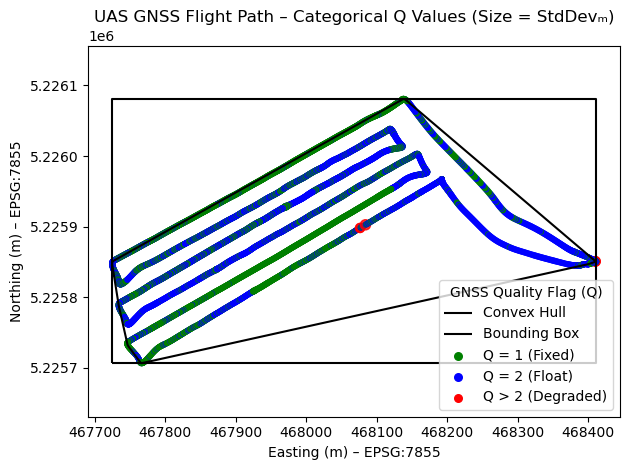

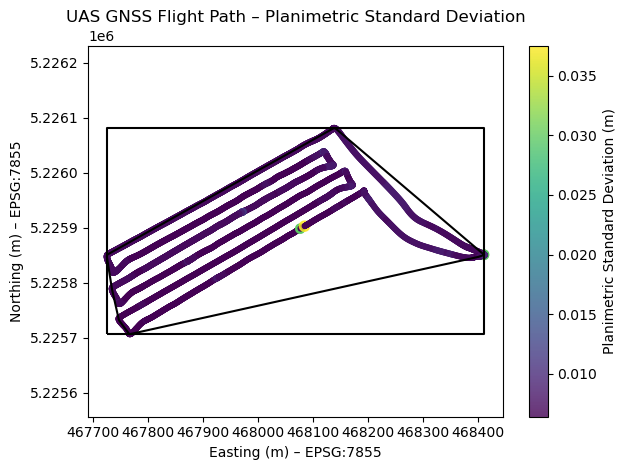

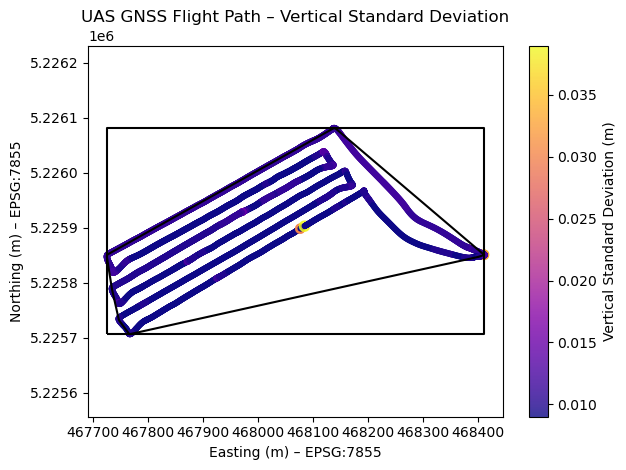

In [3]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# ----------------------------------------------------
# Compute Planimetric Standard Deviation
# ----------------------------------------------------
gdf["SDPlanimetric_m"] = np.sqrt(gdf["SDEast_m"]**2 + gdf["SDNorth_m"]**2)
print(gdf["SDPlanimetric_m"])

# ----------------------------------------------------
# Compute Convex Hull (Shapely 2.0+)
# ----------------------------------------------------
# Note: convex_hull is a PROPERTY, not a function — no ()
convex_hull = gdf.union_all().convex_hull
convex_gdf = gpd.GeoDataFrame(geometry=[convex_hull], crs=gdf.crs)

# ----------------------------------------------------
# Compute Bounding Box
# ----------------------------------------------------
minx, miny, maxx, maxy = gdf.total_bounds
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=gdf.crs)

# ----------------------------------------------------
# Optional: export to GeoPackage
# ----------------------------------------------------
convex_gdf.to_file("uas_flight.gpkg", layer="convex_hull", driver="GPKG")
bbox_gdf.to_file("uas_flight.gpkg", layer="bbox", driver="GPKG")

# ----------------------------------------------------
# Print geometric summaries
# ----------------------------------------------------
print(f"Convex hull area: {convex_hull.area:.2f} m²")
print(f"Convex hull perimeter: {convex_hull.length:.2f} m")
print(f"Bounding box width:  {maxx - minx:.2f} m")
print(f"Bounding box height: {maxy - miny:.2f} m")
print(f"Bounding box area:   {bbox.area:.2f} m²")

# ----------------------------------------------------
# Define Q-colour logic
# ----------------------------------------------------
conditions = [
    gdf["Q"] == 1,
    gdf["Q"] == 2,
    gdf["Q"] > 2
]
choices = ["green", "blue", "red"]
colors = np.select(conditions, choices, default="lightgrey")

# ----------------------------------------------------
# Plot 1: Q Values
# ----------------------------------------------------
plt.figure()
plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=colors,
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Categorical Q Values (Size = StdDevₘ)")
plt.axis("equal")

# Manual legend
plt.scatter([], [], color="green", s=30, label="Q = 1 (Fixed)")
plt.scatter([], [], color="blue", s=30, label="Q = 2 (Float)")
plt.scatter([], [], color="red", s=30, label="Q > 2 (Degraded)")
plt.legend(title="GNSS Quality Flag (Q)", loc="best")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 2: Planimetric SD
# ----------------------------------------------------
plt.figure()
GNSS_plot_2 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDPlanimetric_m"],
    cmap="viridis",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Planimetric Standard Deviation")
plt.axis("equal")

cb = plt.colorbar(GNSS_plot_2)
cb.set_label("Planimetric Standard Deviation (m)")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 3: Vertical SD
# ----------------------------------------------------
plt.figure()
GNSS_plot_3 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDHeight_m"],
    cmap="plasma",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)
convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.5, label="Bounding Box")
plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Vertical Standard Deviation")
plt.axis("equal")

cb2 = plt.colorbar(GNSS_plot_3)
cb2.set_label("Vertical Standard Deviation (m)")

plt.tight_layout()
plt.show()


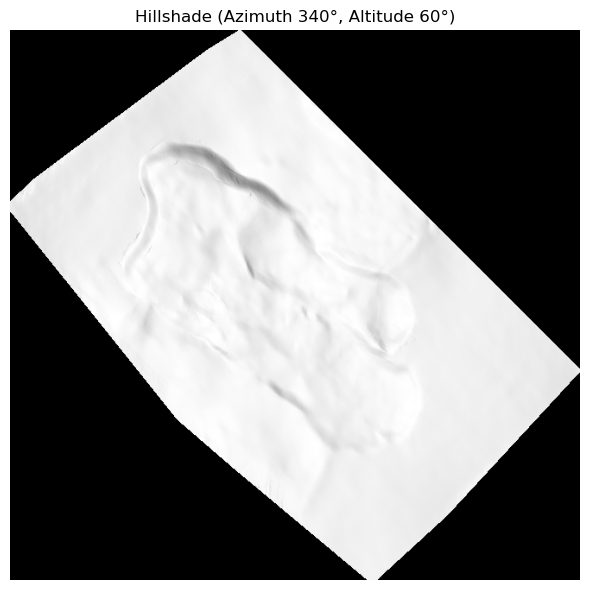

Hillshade raster written: Homehill_2020_Hillshade.tif


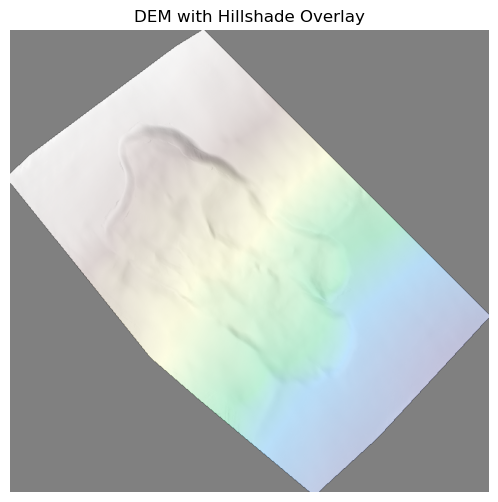

the time to run script was 0.8553531999932602 seconds
the time to run the hillshade was 0.28062929993029684 seconds


In [4]:
import rasterio

time_0 = time.perf_counter()

dem_path = "Homehill_2020_DSM_30cm.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1, masked = True)
    transform = src.transform
    crs = src.crs
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]

azimuth_deg = 340
altitude_deg = 60

azimuth_rad = np.radians(360.0 - azimuth_deg + 90.0)
altitude_rad = np.radians(altitude_deg)

dy, dx = np.gradient(dem.filled(np.nan), pixel_size_y, pixel_size_x)

slope_rad = np.arctan(np.sqrt(dy**2 + dx**2))
aspect_rad = np.arctan2(-dx, dy)
aspect_rad = np.where(aspect_rad < 0, 2 * np.pi + aspect_rad, aspect_rad)

time_1 = time.perf_counter()

# --- Hillshade formula ---
hillshade = (
    np.sin(altitude_rad) * np.cos(slope_rad)
    + np.cos(altitude_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad)
)

# Scale to 0–255 for display
# Clip valid range and replace NaNs with 0 before casting
hillshade_scaled = np.clip(hillshade, 0, 1)
hillshade_scaled = np.where(np.isnan(hillshade_scaled), 0, hillshade_scaled)
hillshade_scaled = (hillshade_scaled * 255).astype(np.uint8)


# --- Plot results ---
plt.figure(figsize=(8,6))
plt.imshow(hillshade_scaled, cmap="gray")
plt.title("Hillshade (Azimuth 340°, Altitude 60°)")
plt.axis("off")
plt.tight_layout()
plt.show()

time_hillshade = time.perf_counter() - time_1
# --- write hillshade to GeoTIFF ---
out_path = "Homehill_2020_Hillshade.tif"
with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=hillshade_scaled.shape[0],
    width=hillshade_scaled.shape[1],
    count=1,
    dtype=np.uint8,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(hillshade_scaled, 1)

print(f"Hillshade raster written: {out_path}")

plt.figure(figsize=(8,6))
plt.imshow(dem, cmap="terrain", alpha=0.5)
plt.imshow(hillshade_scaled, cmap="gray", alpha=0.5)
plt.title("DEM with Hillshade Overlay")
plt.axis("off")
plt.show()

time_script = time.perf_counter() - time_0

print(f"the time to run script was {time_script} seconds")
print(f"the time to run the hillshade was {time_hillshade} seconds")

In [5]:
from pathlib import Path

# ----------------------------------------------------
# File paths
# ----------------------------------------------------
infile = "Homehill_2020_DSM_30cm.tif"

# ----------------------------------------------------
# Load DEM
# ----------------------------------------------------
with rasterio.open(infile) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        dem[dem == nodata] = np.nan  # replace nodata with NaN
    transform = src.transform
    crs = src.crs
    cellsize = transform[0]
    profile = src.profile

nrows, ncols = dem.shape
print("Loaded DEM:", np.nanmin(dem), "to", np.nanmax(dem))

# ----------------------------------------------------
# Prepare empty arrays
# ----------------------------------------------------
mean_slope = np.full((nrows, ncols), np.nan, dtype=np.float32)
min_slope  = np.full((nrows, ncols), np.nan, dtype=np.float32)
max_slope  = np.full((nrows, ncols), np.nan, dtype=np.float32)

# ----------------------------------------------------
# Define FM-simple slope function (NaN-safe)
# ----------------------------------------------------
def fm_simple_kernel(center, north, south, east, west, cellsize):
    """Return mean, min, max slope (°) for the 5-cell cross."""
    diffs = np.abs(np.array([center - north,
                             center - south,
                             center - east,
                             center - west],
                             dtype=float))
    diffs = diffs[np.isfinite(diffs)]  # remove NaNs if any
    if diffs.size == 0:
        return np.nan, np.nan, np.nan

    slopes_deg = np.degrees(np.arctan(diffs / cellsize))
    mean_s = np.nanmean(slopes_deg)
    min_s  = np.nanmin(slopes_deg)
    max_s  = np.nanmax(slopes_deg)
    return mean_s, min_s, max_s

# ----------------------------------------------------
# Move the 5-cell kernel across the DEM
# ----------------------------------------------------
for r in range(1, nrows - 1):
    for c in range(1, ncols - 1):
        # Skip if the centre or any neighbour is NaN
        window = dem[r-1:r+2, c-1:c+2]
        if np.isnan(window).any():
            continue

        center = dem[r, c]
        north  = dem[r - 1, c]
        south  = dem[r + 1, c]
        east   = dem[r, c + 1]
        west   = dem[r, c - 1]

        mean_val, min_val, max_val = fm_simple_kernel(center, north, south, east, west, cellsize)
        mean_slope[r, c] = mean_val
        min_slope[r, c]  = min_val
        max_slope[r, c]  = max_val

# ----------------------------------------------------
# Write outputs
# ----------------------------------------------------
profile.update(dtype="float32", count=1, nodata=np.nan)

with rasterio.open("Homehill_DEM_Slope_FM_mean.tif", "w", **profile) as dst:
    dst.write(mean_slope, 1)
with rasterio.open("Homehill_DEM_Slope_FM_min.tif", "w", **profile) as dst:
    dst.write(min_slope, 1)
with rasterio.open("Homehill_DEM_Slope_FM_max.tif", "w", **profile) as dst:
    dst.write(max_slope, 1)

# ----------------------------------------------------
# Diagnostics
# ----------------------------------------------------
print("✅ FM-simple slope rasters (mean, min, max) written successfully.")
print(f"Mean slope range: {np.nanmin(mean_slope):.2f} – {np.nanmax(mean_slope):.2f}°")
print(f"Min slope range:  {np.nanmin(min_slope):.2f} – {np.nanmax(min_slope):.2f}°")
print(f"Max slope range:  {np.nanmin(max_slope):.2f} – {np.nanmax(max_slope):.2f}°")


Loaded DEM: 49.71183776855469 to 100.39253234863281
✅ FM-simple slope rasters (mean, min, max) written successfully.
Mean slope range: 0.66 – 46.86°
Min slope range:  0.00 – 40.20°
Max slope range:  0.99 – 60.89°


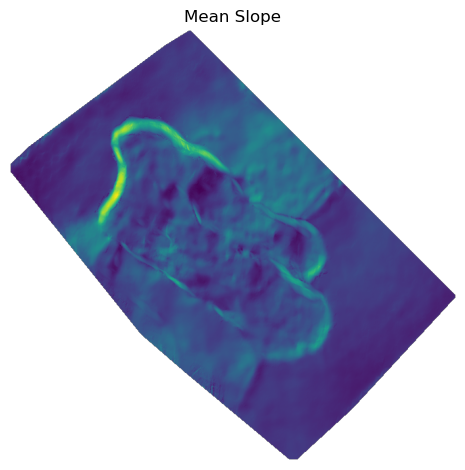

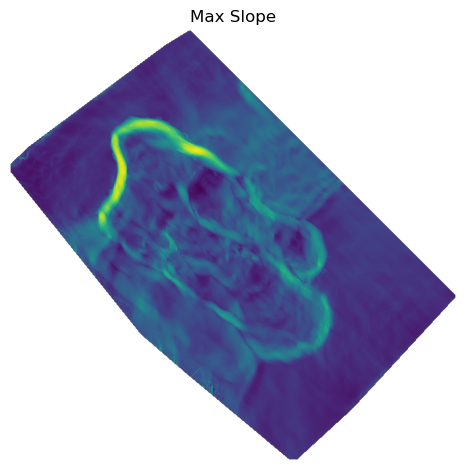

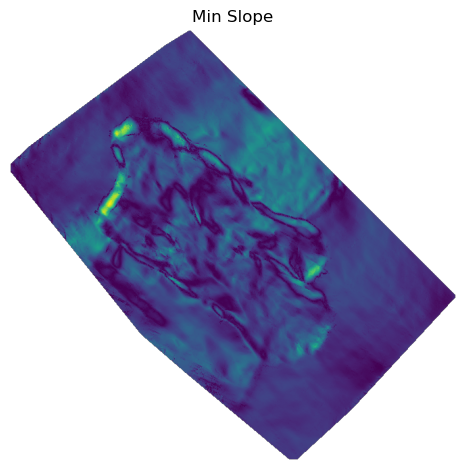

In [6]:
plt.figure()
mean_vectorise = plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.imshow(mean_slope, cmap="viridis")
plt.title("Mean Slope")
plt.axis("off")
plt.tight_layout()
plt.show()

max_vectorise = plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.imshow(max_slope, cmap="viridis")
plt.title("Max Slope")
plt.axis("off")
plt.tight_layout()
plt.show()

min_vectorise = plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.imshow(min_slope, cmap="viridis")
plt.title("Min Slope")
plt.axis("off")
plt.tight_layout()
plt.show()


In [7]:
# ----------------------------------------------------
# File paths
# ----------------------------------------------------
infile = "Homehill_2020_DSM_30cm.tif"

# ----------------------------------------------------
# Load DEM
# ----------------------------------------------------
with rasterio.open(infile) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        dem[dem == nodata] = np.nan
    transform = src.transform
    crs = src.crs
    cellsize = transform[0]
    profile = src.profile

nrows, ncols = dem.shape
print("Loaded DEM:", np.nanmin(dem), "to", np.nanmax(dem))

# ----------------------------------------------------
# Prepare empty output arrays
# ----------------------------------------------------
mean_slope_1 = np.full((nrows, ncols), np.nan, dtype=np.float32)
min_slope_1  = np.full((nrows, ncols), np.nan, dtype=np.float32)
max_slope_1  = np.full((nrows, ncols), np.nan, dtype=np.float32)

# ----------------------------------------------------
# Define FM-simple kernel for 9x9 cross (radius = 4)
# ----------------------------------------------------
def fm_simple_kernel_9x9(center, north, south, east, west, horiz_dist):
    """Return mean, min, max slope (°) using outermost N/S/E/W cells."""
    diffs = np.abs(np.array([center - north,
                             center - south,
                             center - east,
                             center - west], dtype=float))
    diffs = diffs[np.isfinite(diffs)]   # drop NaNs
    if diffs.size == 0:
        return np.nan, np.nan, np.nan

    slopes_deg = np.degrees(np.arctan(diffs / horiz_dist))
    return np.nanmean(slopes_deg), np.nanmin(slopes_deg), np.nanmax(slopes_deg)

# ----------------------------------------------------
# Move 9x9 cross-shaped kernel over DEM
# ----------------------------------------------------
radius = 4  # 9x9 = radius of 4 cells
for r in range(radius, nrows - radius):
    for c in range(radius, ncols - radius):
        # Gather centre + outermost N,S,E,W
        window_vals = [dem[r, c],
                       dem[r - radius, c],  # north
                       dem[r + radius, c],  # south
                       dem[r, c + radius],  # east
                       dem[r, c - radius]]  # west

        # Skip if any are NaN
        if np.any(np.isnan(window_vals)):
            continue

        center = window_vals[0]
        north, south, east, west = window_vals[1:]
        mean_val, min_val, max_val = fm_simple_kernel_9x9(center, north, south, east, west, radius * cellsize)
        mean_slope_1[r, c] = mean_val
        min_slope_1[r, c]  = min_val
        max_slope_1[r, c]  = max_val

# ----------------------------------------------------
# Write outputs
# ----------------------------------------------------
profile.update(dtype="float32", count=1, nodata=np.nan)

with rasterio.open("Homehill_DEM_Slope_FM9x9_mean.tif", "w", **profile) as dst:
    dst.write(mean_slope_1, 1)
with rasterio.open("Homehill_DEM_Slope_FM9x9_min.tif", "w", **profile) as dst:
    dst.write(min_slope_1, 1)
with rasterio.open("Homehill_DEM_Slope_FM9x9_max.tif", "w", **profile) as dst:
    dst.write(max_slope_1, 1)

# ----------------------------------------------------
# Diagnostics
# ----------------------------------------------------
print("✅ FM-simple 9×9 (outermost N,S,E,W) slope rasters written successfully.")
print(f"Mean slope range: {np.nanmin(mean_slope_1):.2f} – {np.nanmax(mean_slope_1):.2f}°")
print(f"Min slope range:  {np.nanmin(min_slope_1):.2f} – {np.nanmax(min_slope_1):.2f}°")
print(f"Max slope range:  {np.nanmin(max_slope_1):.2f} – {np.nanmax(max_slope_1):.2f}°")

Loaded DEM: 49.71183776855469 to 100.39253234863281
✅ FM-simple 9×9 (outermost N,S,E,W) slope rasters written successfully.
Mean slope range: 0.88 – 44.41°
Min slope range:  0.00 – 38.81°
Max slope range:  1.30 – 59.49°


In [ ]:
import numpy as np
import rasterio

# ----------------------------------------------------
# Load DEM
# ----------------------------------------------------
infile = "Homehill_2020_DSM_30cm.tif"

with rasterio.open(infile) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        dem[dem == nodata] = np.nan
    transform = src.transform
    crs = src.crs
    cellsize = transform[0]
    profile = src.profile

nrows, ncols = dem.shape

# ----------------------------------------------------
# Prepare empty output arrays
# ----------------------------------------------------
surface_area = np.full((nrows, ncols), np.nan, dtype=np.float32)
area = np.full((nrows, ncols), cellsize**2, dtype=np.float32)
ratio = np.full((nrows, ncols), np.nan, dtype=np.float32)

# ----------------------------------------------------
# Define kernel-based function for surface area ratio
# ----------------------------------------------------
def area_ratio_kernel(center, north, south, east, west,
                      northeast, northwest, southeast, southwest,
                      cellsize):
    """
    Compute local surface area (SA) and ratio using Heron's formula
    between the center cell and its 8 neighbours.
    """

    # --- Step 1: elevation differences ---
    a = np.array([
        center - north,
        center - south,
        center - east,
        center - west,
        center - northeast,
        center - northwest,
        center - southeast,
        center - southwest,
        south - southwest,
        south - southeast,
        west - northwest,
        west - southwest,
        north - northwest,
        north - northeast,
        east - northeast,
        east - southeast
    ], dtype=float)

    # --- Step 2: horizontal distances ---
    b = np.array([
        cellsize, cellsize, cellsize, cellsize,
        np.sqrt(2) * cellsize, np.sqrt(2) * cellsize,
        np.sqrt(2) * cellsize, np.sqrt(2) * cellsize,
        cellsize, cellsize, cellsize, cellsize,
        cellsize, cellsize, cellsize, cellsize
    ], dtype=float)

    # --- Step 3: side length (3D) ---
    c = np.sqrt(a**2 + b**2)

    # --- Step 4: Heron's formula for each small triangle ---
    s = (a + b + c) / 2
    SA_each = np.sqrt(np.abs(s * (s - a) * (s - b) * (s - c)))

    # --- Step 5: total surface area (sum of triangle areas) ---
    SA_total = np.nansum(SA_each)

    # --- Step 6: flat (planimetric) cell area ---
    A_plan = cellsize**2

    # --- Step 7: surface-area ratio ---
    ratio_val = SA_total / A_plan

    return SA_total, A_plan, ratio_val


# ----------------------------------------------------
# Apply the kernel across the DEM
# ----------------------------------------------------
for r in range(1, nrows - 1):
    for c in range(1, ncols - 1):
        # Skip NaN centre cells
        if np.isnan(dem[r, c]):
            continue

        center = dem[r, c]
        north  = dem[r - 1, c]
        south  = dem[r + 1, c]
        east   = dem[r, c + 1]
        west   = dem[r, c - 1]
        northeast = dem[r - 1, c + 1]
        northwest = dem[r - 1, c - 1]
        southeast = dem[r + 1, c + 1]
        southwest = dem[r + 1, c - 1]

        # If any are NaN, skip
        if np.any(np.isnan([north, south, east, west,
                            northeast, northwest, southeast, southwest])):
            continue

        SA, A, R = area_ratio_kernel(center, north, south, east, west,
                                     northeast, northwest, southeast, southwest,
                                     cellsize)

        surface_area[r, c] = SA
        area[r, c] = A
        ratio[r, c] = R

# ----------------------------------------------------
# Write outputs
# ----------------------------------------------------
profile.update(dtype="float32", count=1, nodata=np.nan)

with rasterio.open("Homehill_DEM_SurfaceArea.tif", "w", **profile) as dst:
    dst.write(surface_area, 1)
with rasterio.open("Homehill_DEM_FlatArea.tif", "w", **profile) as dst:
    dst.write(area, 1)
with rasterio.open("Homehill_DEM_AreaRatio.tif", "w", **profile) as dst:
    dst.write(ratio, 1)

# ----------------------------------------------------
# Diagnostic output
# ----------------------------------------------------
print("✅ Surface area, planar area, and area ratio rasters written successfully.")
print(f"Surface area range: {np.nanmin(surface_area):.4f} – {np.nanmax(surface_area):.4f}")
print(f"Area ratio range: {np.nanmin(ratio):.4f} – {np.nanmax(ratio):.4f}")


In [ ]:
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Plot histograms of Surface Area, Planar Area, and Area Ratio
# ----------------------------------------------------

# Remove NaNs for plotting
valid_surface = surface_area[np.isfinite(surface_area)]
valid_area    = area[np.isfinite(area)]
valid_ratio   = ratio[np.isfinite(ratio)]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Histogram 1: Surface Area ---
axes[0].hist(valid_surface, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Surface Area Distribution", fontsize=12)
axes[0].set_xlabel("Surface Area (m²)")
axes[0].set_ylabel("Frequency")
axes[0].legend([f"Mean = {np.nanmean(valid_surface):.4f} m²"], loc="upper right")

# --- Histogram 2: Planimetric Area ---
axes[1].hist(valid_area, bins=50, color="darkorange", edgecolor="black", alpha=0.7)
axes[1].set_title("Planimetric Area Distribution", fontsize=12)
axes[1].set_xlabel("Flat Area (m²)")
axes[1].legend([f"Mean = {np.nanmean(valid_area):.4f} m²"], loc="upper right")

# --- Histogram 3: Surface Area Ratio ---
axes[2].hist(valid_ratio, bins=50, color="forestgreen", edgecolor="black", alpha=0.7)
axes[2].set_title("Surface Area Ratio (SA/PA)", fontsize=12)
axes[2].set_xlabel("Area Ratio (–)")
axes[2].legend([
    f"Mean = {np.nanmean(valid_ratio):.3f}\nMin = {np.nanmin(valid_ratio):.3f}\nMax = {np.nanmax(valid_ratio):.3f}"
], loc="upper right")

# Adjust layout
plt.suptitle("Distributions of Surface Area Metrics – Home Hill DEM", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
